In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import itertools
import seaborn as sns
import os
from torchvision import models
import torch.nn.functional as F

# Parameters

In [2]:

latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 50
device = 'cpu'

# Define noise types and parameters
noise_types = ['normal', 'uniform', 'lognormal', 'exponential', 'gamma', 'poisson', 'random_binary']
noise_params = {
    'normal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'uniform': {'noise_min': [-1.0, 0.0], 'noise_max': [0.5, 1.0]},
    'lognormal': {'noise_std': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0], 'noise_mean': [0.0, 1.0, -1.0, 5.0, -5.0]},
    'exponential': {'noise_lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]},
    'gamma': {'noise_alpha': [1.0, 2.0, 3.0], 'noise_beta': [1.0, 2.0]},
    'poisson': {'noise_lambda': [1.0, 2.0, 5.0]},
    'random_binary': {}
}


# Load models

In [3]:

def load_models_by_id(run_id, model_dir='models'):
    # List all files in the model directory
    files = os.listdir(model_dir)
    
    # Find the correct discriminator and generator file based on the run_id
    discriminator_file = next((f for f in files if f.startswith(f"discriminator_{run_id}_") and f.endswith(".pth")), None)
    generator_file = next((f for f in files if f.startswith(f"generator_{run_id}_") and f.endswith(".pth")), None)

    if discriminator_file is None or generator_file is None:
        raise FileNotFoundError(f"Model files for run ID {run_id} not found.")
    
    # Construct full file paths
    discriminator_path = os.path.join(model_dir, discriminator_file)
    generator_path = os.path.join(model_dir, generator_file)
    
    # Load the discriminator and generator models
    discriminator = torch.load(discriminator_path, weights_only=True)
    generator = torch.load(generator_path, weights_only=True)

    return discriminator, generator

In [4]:

# Define Generator
class Generator(nn.Module):
    def __init__(self, input_size=latent_size, hidden_size=hidden_size, output_size=image_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))
        return x

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=image_size, hidden_size=hidden_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        # x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x
    
# Load generator and discriminator
noise_dim = latent_size


# Instantiate the models with the known architecture
G = Generator()
D = Discriminator()


# Load the saved models from .pth files
run_id = 'xvtgqt97'  # Example run ID (without timestamp)
discriminator, generator = load_models_by_id(run_id)

# Load the state dict into the models
G.load_state_dict(generator)
D.load_state_dict(discriminator)

# Set the models to evaluation mode
G.eval()
D.eval()

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

C = Net()
# Load the trained classifier model
classifier = torch.load('mnist_classifier/mnist_cnn.pt', weights_only=True)
C.load_state_dict(classifier)
C.eval()  # Set the model to evaluation mode

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Define functions

In [6]:
# Function for generating noise as given
def generate_noise(batch_size, latent_size, noise_type='normal', config=None):
    if noise_type == 'normal':
        z = torch.randn(batch_size, latent_size).to(device) * config['noise_std'] + config['noise_mean']

    elif noise_type == 'uniform':
        z = torch.rand(batch_size, latent_size).to(device) * (config['noise_max'] - config['noise_min']) + config['noise_min']

    elif noise_type == 'exponential':
        z = torch.distributions.Exponential(config['noise_lambda']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'lognormal':
        z = torch.distributions.LogNormal(config['noise_mean'], config['noise_std']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'gamma':
        z = torch.distributions.Gamma(config['noise_alpha'], config['noise_beta']).sample((batch_size, latent_size)).to(device)

    elif noise_type == 'poisson':
        z = torch.poisson(torch.full((batch_size, latent_size), config['noise_lambda'])).to(device)

    elif noise_type == 'random_binary':
        z = torch.randint(0, 2, (batch_size, latent_size)).float().to(device)  # Binary random noise

    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")

    return z

In [7]:
def plot_noise_raw(noise_type_, config_, z):
    # Prepare to plot
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes

    # Plot the provided noise data
    ax.plot(z.cpu().numpy().flatten())  # Plotting the flattened noise

    # Create title string from noise type and config
    config_str = ", ".join(f"{k}={v}" for k, v in config_.items())
    ax.set_title(f"{noise_type_.capitalize()} Noise\n{config_str}")
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')

    # Show the plot
    plt.show()

In [8]:
def plot_noise_histogram(z, noise_type, config):
    z_numpy = z.cpu().numpy().flatten()

    # Plot distribution using Kernel Density Estimation (KDE)
    fig, ax = plt.subplots(figsize=(15, 8))  # Single plot, no need for multiple axes
    sns.kdeplot(z_numpy, fill=True)

    # Format the plot title and labels
    config_str = ", ".join(f"{k}={v}" for k, v in config.items())
    ax.set_title(f"{noise_type.capitalize()} Noise\n{config_str}", fontsize=20)
    ax.set_xlabel('Value', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=18)  # Tick labels font size



In [9]:
def visualize_noise_as_image(z, index=0):
    """
    Visualizes a single noise vector as a 28x28 grayscale image.

    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, latent_size).
        index (int): The index of the noise vector in the batch to visualize.
    """
    # Extract the specific noise vector and reshape it to 28x28
    side = int(np.sqrt(len(z[0])))
    noise_image = z[index].reshape(side, side).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray')
    plt.title(f"Noise Vector as {side}x{side} Image (Index {index})")
    plt.axis('off')
    plt.show()

In [10]:
def visualize_fake_image(z, index=0):
    """
    Visualizes a single noise vector as a 28x28 grayscale image.

    Parameters:
        z (torch.Tensor): The noise vector to visualize, expected shape (batch_size, latent_size).
        index (int): The index of the noise vector in the batch to visualize.
    """
    global D, G

    # Extract the specific noise vector and reshape it to 28x28
    

    fake_images = G(z)
    outputs = D(fake_images)
    score = outputs.mean().item()

    side = int(np.sqrt(len(fake_images[0])))
    noise_image = fake_images[index].reshape(side, side).cpu().detach().numpy()

    # Display the noise as an image
    plt.figure(figsize=(5, 5))
    plt.imshow(noise_image, cmap='gray')
    plt.title(f"Fake image -> score:{score:.3f}")
    plt.axis('off')
    plt.show()

# Generate Noise

In [11]:
noise_params = {
    'normal': {'noise_std': 5.0, 'noise_mean': 1.0}, 
}

noise_type_ = 'normal'
config_ = noise_params[noise_type_]

z = generate_noise(2, latent_size, noise_type_, config_) 

z

tensor([[ -4.7788,  -0.2017,   4.5031,   6.1976,   6.2412,  -3.9828,   5.4374,
           1.8431,  -2.3940,   4.5494,   2.5405,   2.7656,   1.1558,  -9.0517,
           0.5584,   2.5052,   4.2469, -12.9342,  -1.0807,   2.5927, -10.4639,
           7.0701,   5.5007,  -1.7516,   0.3955,   0.7653,   0.0620,  -1.2160,
           0.5385,  -3.9303,  -1.8762,   2.7031,  -1.5240,  -4.8976,  -1.2455,
           3.3377,   1.4926,  -0.3481,   7.6726,  -0.1790,   0.9438,  10.3792,
           6.8353, -12.7103,  -6.9030,  -1.2602,   8.5892,   4.9986,   3.2293,
          -2.0082,   5.9590,   0.8048,   4.6160,   3.4512,   0.3731,   8.4162,
           7.8355,  -6.5538,   3.3129,   0.0683,   8.6590,   8.9857,   5.0145,
          -2.2025],
        [ -4.1599,  -3.2412,   1.4071,  -2.3320,  -1.8195,  -0.9820,   6.2315,
           2.1192,   4.8149,  -2.1194,   8.9578,  -0.7778,   0.1292,   0.9783,
         -10.8270,   2.5914,   6.9531,   2.8562,   4.1790,   0.4937,   4.4914,
          -0.9074,  11.1762,  -1

# Visualize Noise - raw

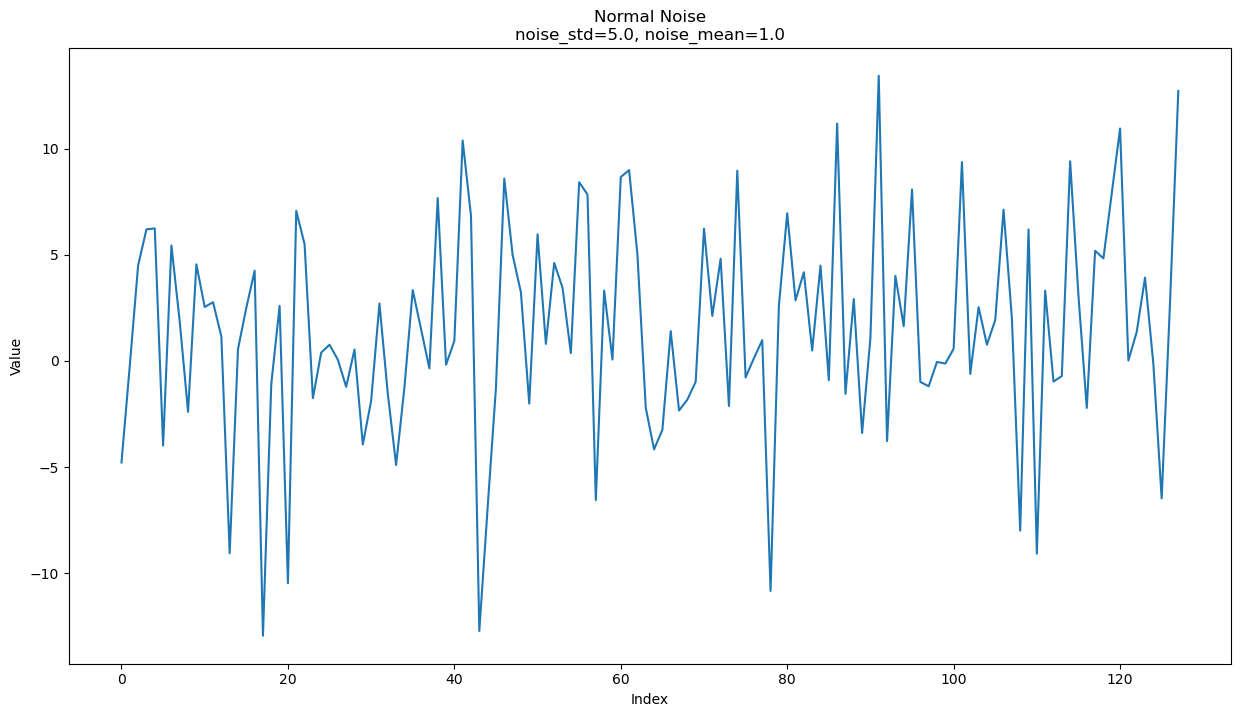

In [12]:
plot_noise_raw(noise_type_, config_, z)

# Visualize noise - distribution

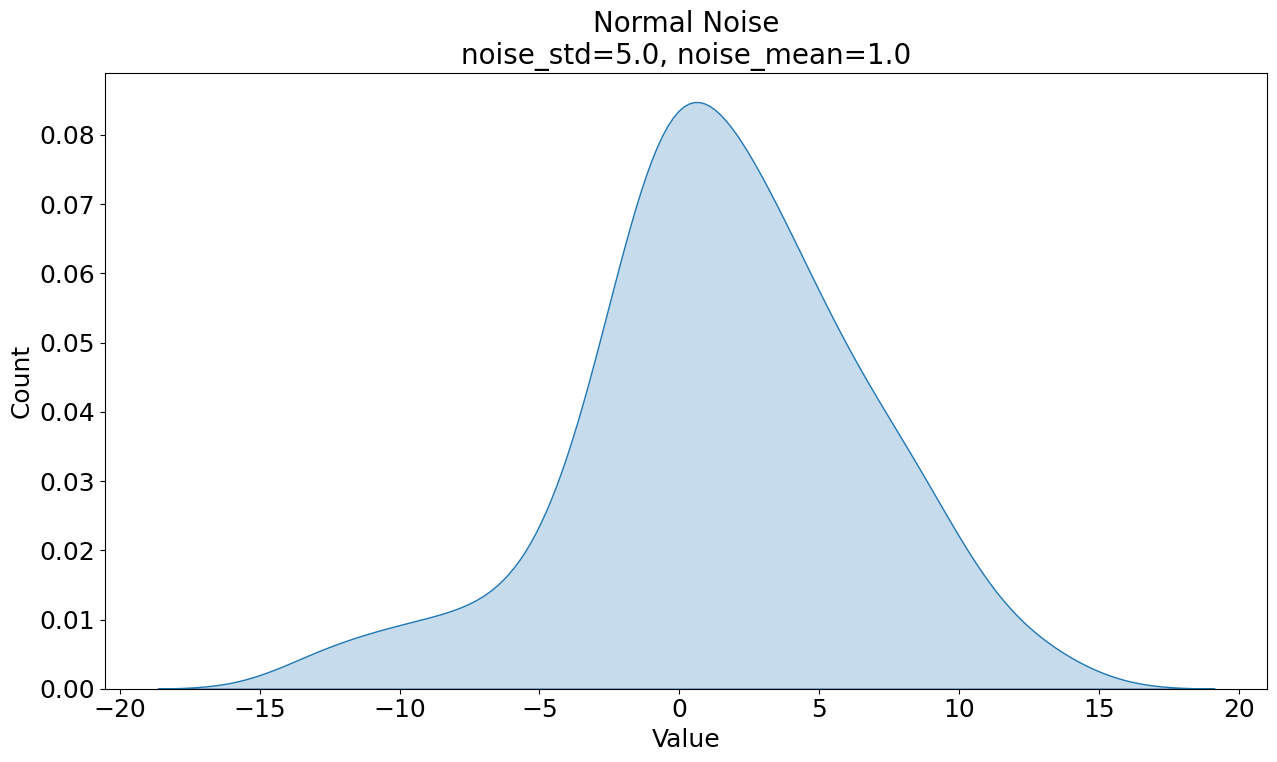

In [13]:
plot_noise_histogram(z, noise_type_, config_, )

# Visualize noise - image

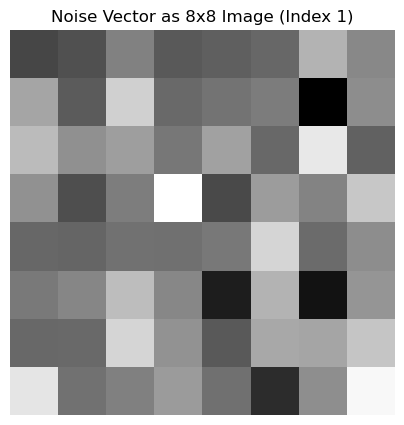

In [14]:
index_ = 1
visualize_noise_as_image(z, index=index_)


# Generate number from noise

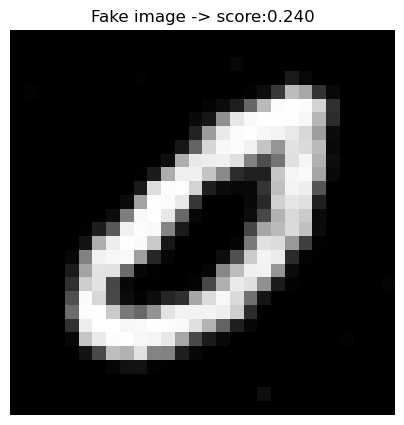

In [15]:
index_ = 0
visualize_fake_image(z, index=index_)

# Multiple runs

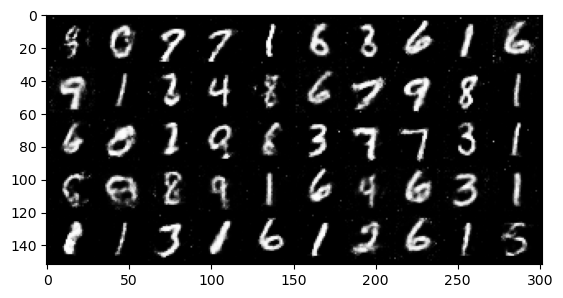

D(G(z)): 0.29


In [16]:
noise_params = {
    'normal': {'noise_std': 5.0, 'noise_mean': 0.0}, 
}

noise_type_ = 'normal'
config_ = noise_params[noise_type_]

z = generate_noise(batch_size, latent_size, noise_type_, config_) 

fake_images = G(z)
outputs = D(fake_images)
fake_score = outputs
reshaped_images = fake_images.view(batch_size, 1, 28, 28)

with torch.no_grad():
    # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    grid = make_grid(reshaped_images, nrow=10, normalize=True)
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()



print(f"D(G(z)): {fake_score.mean().item():.2f}")

# Classifying the fake images

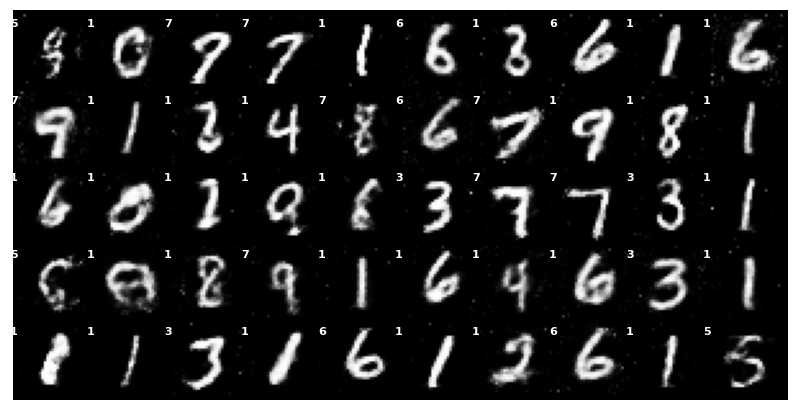

In [17]:
# Classify the images
with torch.no_grad():
    predictions = C(reshaped_images)

# Get the predicted classes
_, predicted_classes = torch.max(predictions, 1)

# Print the predicted classes
# print(predicted_classes)

# Assuming you have a classifier to get the predicted labels for fake images
predicted_labels = predicted_classes

# Reshape and plot images with labels
with torch.no_grad():
    # fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    grid = make_grid(reshaped_images, nrow=10, normalize=True, padding=2)

    # Plot grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    
    # Add predicted labels to the grid
    nrow = 10
    for i in range(batch_size):
        row, col = divmod(i, nrow)
        plt.text(col * (28 + 2), row * (28 + 2) + 5, f"{predicted_labels[i].item()}",
                 color='white', fontsize=8, weight='bold', ha='center', va='center')
    
    plt.axis('off')
    plt.show()


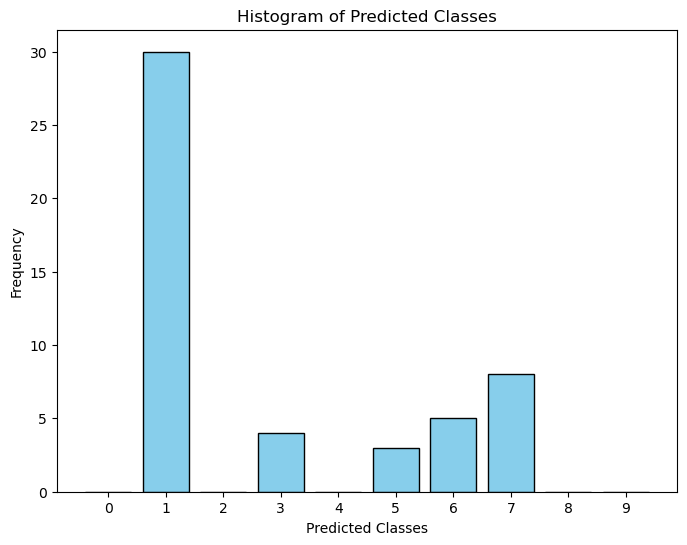

In [18]:

# Plot histogram of predicted classes
plt.figure(figsize=(8, 6))
plt.hist(predicted_classes.cpu().numpy(), bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Predicted Classes')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Classes')
plt.xticks(range(10))  # Assuming classes are from 0 to 9

# Show the plot
plt.show()